In [ ]:
!pip install yfinance
!pip install yahoofinancials
!pip install pyyaml h5py
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install torch

In [119]:
import numpy as np
import pandas as pd

import numpy as np
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf
from yahoofinancials import YahooFinancials

In [120]:
stock_code = '0005.hk'
start_date = '2023-01-01'
interval = '1d' # 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo

In [121]:
df = yf.download(stock_code, start=start_date, interval=interval, progress=False)
df = df.reset_index()
df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
421,2024-09-24,69.900002,70.099998,69.650002,70.099998,70.099998,54986765
422,2024-09-25,70.500000,70.699997,69.550003,69.900002,69.900002,30430898
423,2024-09-26,69.400002,70.050003,69.150002,70.000000,70.000000,34143710
424,2024-09-27,70.199997,70.849998,70.000000,70.599998,70.599998,45551531
425,2024-09-30,70.449997,71.000000,69.949997,70.449997,70.449997,36627980


In [122]:
# Convert 'Date' to datetime and extract useful features
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day_of_Week'] = df['Date'].dt.dayofweek

# Convert cyclical features for Month and Day_of_Week
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_of_Week_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
df['Day_of_Week_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)

# You can drop 'Month', 'Day_of_Week', 'Date', etc., if not needed anymore
df = df.drop(['Date', 'Day', 'Month', 'Year', 'Day_of_Week'], axis=1)

# Now df contains the following columns:
# ['Open', 'High', 'Low', 'Close', 'Volume', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos']

columns = [col for col in df.columns if col not in ['Close', 'Adj Close']] + ['Close', 'Adj Close']
df = df[columns]




In [123]:
# Assuming your dataframe now includes the cyclical date features
data = df.copy()[['Open', 'High', 'Low', 'Volume', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Close', 'Adj Close']].values

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [124]:
import torch
from stock_dataset import StockDataset
from torch.utils.data import DataLoader, Subset

# Define sequence and target lengths
sequence_length = 60  # 60 days of historical data
target_length = 10    # Predict 5 days

# Create dataset
dataset = StockDataset(data, sequence_length, target_length)

def sliding_window_split(dataset, train_size, test_size, final_holdout_size):
    """
    Split the dataset using a sliding window strategy, but keep the final portion for hold-out prediction.
    
    Args:
        dataset: The dataset to split.
        train_size: The number of samples to use for each training window.
        test_size: The number of samples to use for each test window.
        final_holdout_size: The portion to hold out for final validation (not included in training).
    
    Yields:
        train_dataset, test_dataset: The train and test datasets for each iteration.
    """
    # Make sure we keep the final portion out of the training process
    max_index = len(dataset) - final_holdout_size
    
    start = 0
    while start + train_size + test_size <= max_index:
        train_dataset = Subset(dataset, list(range(start, start + train_size)))
        test_dataset = Subset(dataset, list(range(start + train_size, start + train_size + test_size)))
        yield train_dataset, test_dataset
        start += test_size  # Slide the window forward

In [125]:
import torch
import torch.nn as nn
from models.stock_predictor import StockPredictor

# Model parameters
input_size = data.shape[1]  # Number of input features (e.g., 10 features)
print('The num of features', input_size)
hidden_size = 128
num_heads = 4
num_layers = 4
output_size = target_length  # Predict 10 days
dropout = 0.1
batch_size = 32

# Initialize the model
model = StockPredictor(input_size, hidden_size, num_heads, num_layers, output_size, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Example: Sliding window for training with hold-out
train_size = int(0.6 * len(dataset))  # 60% of the data
test_size = int(0.1 * len(dataset))   # 10% window for validation
final_holdout_size = int(0.05 * len(dataset))   # Hold out the last 10% of data


# Set the number of epochs for training
epochs = 10  # Example: Train for 50 epochs

print('Total trainable params {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

for epoch in range(epochs):
  the_last_loss = 0.0
  # Sliding window training
  for train_dataset, test_dataset in sliding_window_split(dataset, train_size, test_size, final_holdout_size):
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
      
      # Training and testing logic here
      model.train()
      for batch_X, batch_y in train_loader:
          optimizer.zero_grad()
          output = model(batch_X)
          loss = criterion(output, batch_y)
          the_last_loss = loss.item()
          loss.backward()
          optimizer.step()

  
  print("Final Loss after Epoch: {0}/{1} is {2}".format(epoch + 1, epochs, the_last_loss))
  

The num of features 10
Total trainable params 2374794


/opt/anaconda3/envs/stock_predictor/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Final Loss after Epoch: 1/10 is 0.17523764073848724
Final Loss after Epoch: 2/10 is 0.12817522883415222
Final Loss after Epoch: 3/10 is 0.13287827372550964
Final Loss after Epoch: 4/10 is 0.10970841348171234
Final Loss after Epoch: 5/10 is 0.11007187515497208
Final Loss after Epoch: 6/10 is 0.09204350411891937
Final Loss after Epoch: 7/10 is 0.08204680681228638
Final Loss after Epoch: 8/10 is 0.06444164365530014
Final Loss after Epoch: 9/10 is 0.05118613317608833
Final Loss after Epoch: 10/10 is 0.043884944170713425


In [126]:

def eval(last_x_days):

  # Assuming your dataframe now includes the cyclical date features
  prediction_input =  df.tail(last_x_days)[['Open', 'High', 'Low', 'Volume', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Close', 'Adj Close']].values

  # Normalize the data
  input_scaler = MinMaxScaler()
  input_data = input_scaler.fit_transform(prediction_input)
    
  # Step 1: Extract the 'Adj Close' column from the data
  adj_close_data = df.tail(last_x_days)[['Adj Close']].values

  # Step 2: Initialize a separate MinMaxScaler for 'Adj Close'
  adj_close_scaler = MinMaxScaler()

  # Step 3: Fit the scaler on the 'Adj Close' column only
  adj_close_scaled = adj_close_scaler.fit_transform(adj_close_data)


  # Example prediction on the last sequence in the test set
  model.eval()
  with torch.no_grad():
      prediction = model(torch.tensor(input_data, dtype=torch.float32).unsqueeze(0))

      adj_close_prediction = adj_close_scaler.inverse_transform(prediction.numpy())
      
      print("Next {0} days 'Adj Close' prediction: {1}".format(target_length, adj_close_prediction))
      return adj_close_prediction


Next 10 days 'Adj Close' prediction: [[70.320045 70.36391  70.27592  70.27553  70.33812  70.38385  70.24763
  70.31953  70.2934   70.29598 ]]
Next 10 days 'Adj Close' prediction: [[69.47952  69.56863  69.25808  69.31457  69.383865 69.647865 69.204735
  69.303116 69.28584  69.295   ]]
Next 10 days 'Adj Close' prediction: [[68.89843  69.364    68.69495  68.76222  69.01912  69.40768  68.67522
  68.9571   68.892235 68.97307 ]]
Next 10 days 'Adj Close' prediction: [[68.42258  69.20991  68.60456  68.73734  68.97395  69.03081  68.804535
  68.84118  68.97329  69.040855]]


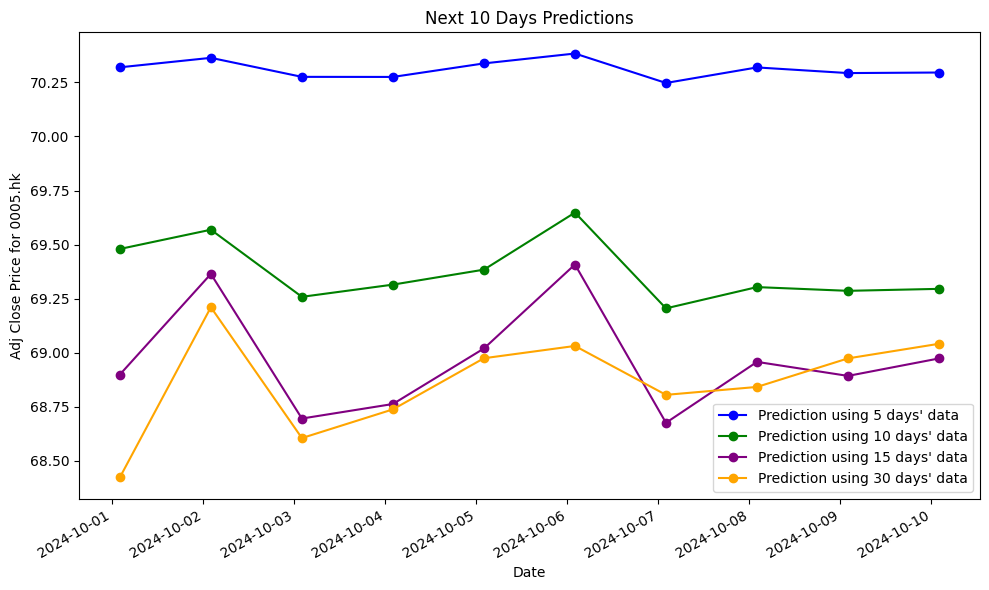

In [127]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

look_bank_days = [5, 10, 15, 30]
colors = ['blue', 'green', 'purple', 'orange']  # Different colors for each line

plt.figure(figsize=(10, 6))

for i, days in enumerate(look_bank_days):
    adj_close_prediction = eval(days)  # Assuming `eval` returns appropriate prediction data for the given `days`

    # Create a list of dates starting from today
    num_days = target_length  # Assuming prediction gives values for the next N days
    start_date = datetime.today()
    dates = [start_date + timedelta(days=i) for i in range(num_days)]

    # Plotting with different colors and markers
    plt.plot(dates, adj_close_prediction[0], label=f"Prediction using {days} days' data", 
             color=colors[i], marker='o')

# Format the x-axis to show dates and improve readability
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Adj Close Price for {0}'.format(stock_code))
plt.title(f"Next {target_length} Days Predictions")

# Display the legend (captions)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
